## Simple particle filtering experiment for linear state space model with Gamma noise

In [4]:
#Importing necessary packages
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_discrete
from tqdm import tqdm

#Shape parameter for the observation dynamics
gamma_k = 8
#Timesteps to be simulated
T = 50
#Standard deviation for underlying random walk with drift
x_sigma = 4

def ydynamics(y_t, x_t, gamma_k):
    #Observations y_t depending on x_t in a Gamma distributed way.
    #Shape = gamma_k, Scale = np.sqrt(np.abs(x_t))
    theta = np.sqrt(np.abs(x_t))
    return (1/(math.factorial(gamma_k-1)*(theta)**gamma_k))*(y_t**(gamma_k-1))*np.exp(-(y_t/theta))

def generate_x(n = T, init = 5):
    #Generates a discrete random walk with constant +1 drift.
    xvals = [init]
    for i in range(n-1):
        xvals.append(np.random.normal(xvals[i]+1,x_sigma))
    return xvals

def generate_y(xvals):
    #Generates observations y given values of x
    yvals = []
    for val in xvals:
        yvals.append(np.random.gamma(gamma_k,np.sqrt(np.abs(val))))
    return yvals

xvals = generate_x()
yvals = generate_y(xvals)

print(f'Generated a signal of length {len(xvals)}.\n')
print(f'First few values of the true signal: {xvals[:5]}')
print(f'Corresponding observations: {yvals[:5]}')

Generated a signal of length 50.

First few values of the true signal: [5, 5.403193917497493, 0.8943245797033592, 4.922498977844715, 7.470496848010768]
Corresponding observations: [25.97543408099387, 28.570656114253005, 4.212392188661001, 15.299653495997878, 18.61455118081717]


## Sequential Importance Sampling

In [5]:
#N: Number of particles
N = 2000

#Init array of particles and corresponding weights
xarr = []
weights = np.ones(N)

#Sequential Importance Sampling Loop
for t in tqdm(range(T)):
    xarr_new = []
    if(t == 0):
        #Initialization Step
        for i in range(N):
            xarr.append([5])
    else:
        for i in range(N):
            #Prediction
            xarr[i].append(np.random.normal(xarr[i][-1] + 1,x_sigma))
            #Update Weights
            weights[i] = (weights[i]*ydynamics(yvals[t],xarr[i][-1], gamma_k))

        #Normalize Weights
        wsum = np.sum(weights)
        for i in range(N):
            weights[i] = weights[i]/wsum
    
        #Particle Resampling
        if t % 2 == 0:
            distrib = rv_discrete(values = (range(N), weights))

            for i in range(N):
                xarr_new.append(xarr[distrib.rvs()].copy())
            xarr = xarr_new
            weights = (1/N)*np.ones(N)

        
xarr = np.array(xarr)
weights = np.array(weights)
print('Finished sequential importance sampling loop.')
print(f'Generated array of particles with shape {xarr.shape}')

100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

Finished sequential importance sampling loop.
Generated array of particles with shape (2000, 50)


## Visualization of Posterior Mean and Confidence Band

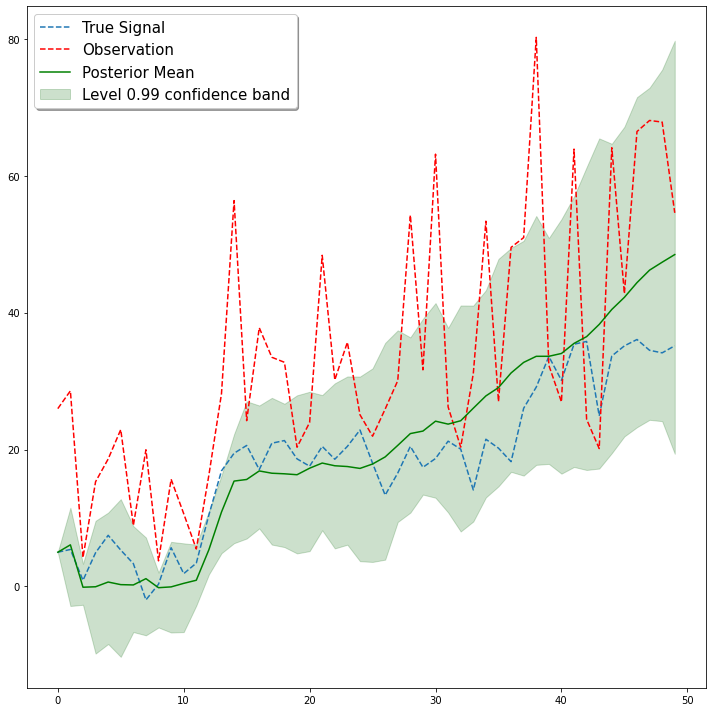

In [13]:
alpha = 0.01

def find_lower(xuniques, wuniques,alpha):
    cumsum = 0
    for i,weight in enumerate(wuniques):
        cumsum += weight
        if cumsum >= alpha/2:
            return i

def find_upper(xuniques, wuniques, alpha):
    cumsum = 0
    for i, weight in enumerate(np.flip(wuniques)):
        cumsum += weight
        if cumsum >= alpha/2:
            return -i-1


lowerbounds = []
upperbounds = []
for idx_sel in range(T):
    sortinds = np.argsort(xarr[:,idx_sel])

    #Make CDF
    xuniques = np.unique(xarr[sortinds,idx_sel], return_counts = True)
    wuniques = []

    cnt = 0
    currweight = 0
    for maxcount in xuniques[1]:
        currweight = 0
        for j in range(maxcount):
            currweight += weights[cnt]
            cnt += 1
        wuniques.append(currweight)
        
    lowerbounds.append(xuniques[0][find_lower(xuniques,wuniques,alpha)])
    upperbounds.append(xuniques[0][find_upper(xuniques,wuniques,alpha)])


#Plot result
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(xvals, label = 'True Signal', linestyle = '--')
ax.plot(yvals, label = 'Observation', linestyle = '--', c = 'red')
ax.plot(np.average(xarr, axis = 0, weights = weights), label = 'Posterior Mean', c = 'green')
ax.fill_between([i for i in range(T)],lowerbounds,upperbounds, alpha = 0.2, label = f'Level {1-alpha} confidence band',
               color = 'darkgreen')
ax.legend(fontsize = 15, shadow = True)
plt.tight_layout()
plt.savefig('SIS_example.png')